In [2]:
%pwd

'c:\\Users\\nepom\\Downloads\\gm-activity-recognition\\notebooks\\training'

In [1]:
# Copyright (c) OpenMMLab. All rights reserved.
import os.path as osp

from mmengine.config import Config
from mmengine.runner import Runner
import time
from mmaction.registry import RUNNERS


def merge_args(cfg, work_dir):
    """Merge CLI arguments to config."""
    cfg.work_dir = work_dir  # Set the work_dir to save the results


def main(config_path, work_dir):
    # Load config from file
    cfg = Config.fromfile(config_path)

    # Merge config if needed
    merge_args(cfg, work_dir)

    # Build the runner from config
    if 'runner_type' not in cfg:
        # Build the default runner
        runner = Runner.from_cfg(cfg)
    else:

        runner = RUNNERS.build(cfg)

    # Start training
    runner.train()


if __name__ == '__main__':
    config_path = "../../configs/pretrained_slowonly_resnet50_gym-keypoint_v2.py"
    work_dir = "../../results/posec3d"
    start_train_time = time.time()
    main(config_path, work_dir)
    end_train_time = time.time()

06/17 12:38:22 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 899502643
    GPU 0: NVIDIA GeForce RTX 4060 Ti
    CUDA_HOME: None
    MSVC: n/a, reason: fileno
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-ge

In [2]:
training_elapsed = end_train_time - start_train_time

print(f"Elapsed inference time: {round(training_elapsed, 4)} seconds")

Elapsed inference time: 2338.2063 seconds


## Model and Training Eval

In [1]:
import json

filepath = "../../results/posec3d/20240617_123818/vis_data/scalars.json"

data = []
with open(filepath, 'r') as file:
    for line in file:
        data.append(json.loads(line))

In [2]:
filtered_indices = [index for index in range(len(data)) if index % 9 == 0]

In [11]:
new_data = []
for idx in filtered_indices:
    new_data.append(data[idx-1])

In [4]:
len(new_data)

20

In [8]:
losses = [data['loss'] for data in new_data]
top1_acc_values = [entry['top1_acc'] for entry in new_data if 'top1_acc' in entry]

In [12]:
# losses = [data['loss'] for data in new_data]
val_top1_acc_values = [entry['acc/top1'] for entry in new_data if 'acc/top1' in entry]

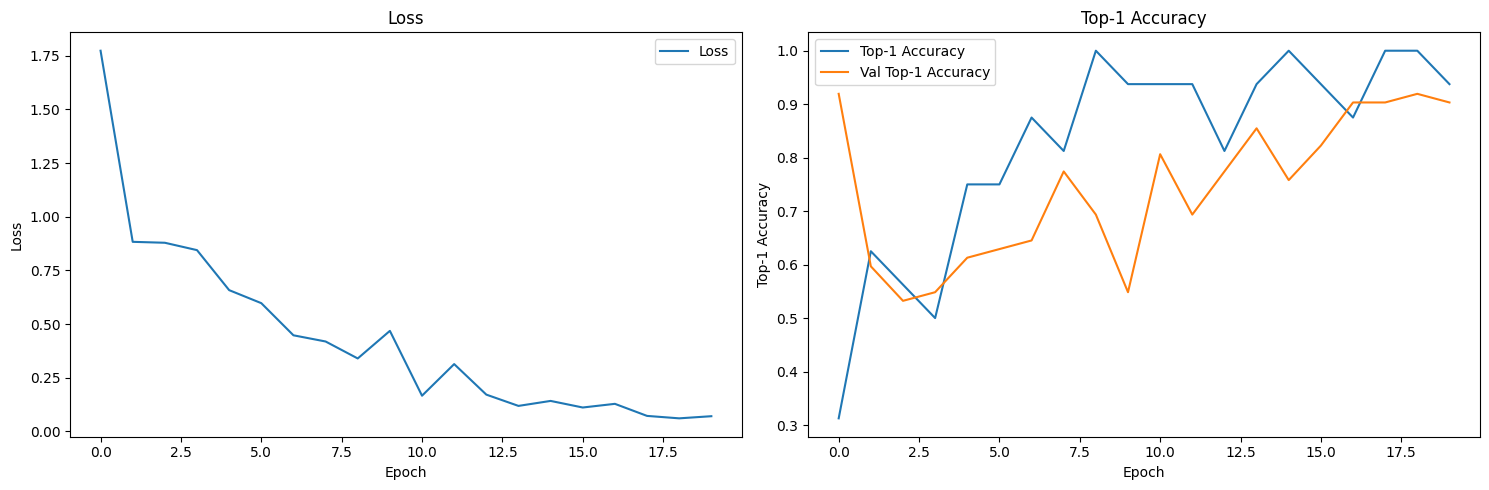

In [13]:
import matplotlib.pyplot as plt


# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss on the second subplot
ax1.plot(losses, label="Loss")
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Top-1 Accuracy on the first subplot
ax2.plot(top1_acc_values, label='Top-1 Accuracy')
ax2.plot(val_top1_acc_values, label='Val Top-1 Accuracy')
ax2.set_title('Top-1 Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Top-1 Accuracy')
ax2.legend()



# Show the plots
plt.tight_layout()
plt.show()


In [14]:
# Copyright (c) OpenMMLab. All rights reserved.
import logging
import tempfile
import torch

from mmengine import dump, list_from_file, load
from mmengine.config import Config, DictAction
from mmengine.evaluator import Evaluator
from mmengine.runner import Runner

from mmaction.evaluation import ConfusionMatrix
from mmaction.registry import DATASETS
from mmaction.utils import register_all_modules


def eval_checkpoint(
    config_path,
    ckpt_or_result,
    output=None,
    show=False,
    show_path=None,
    include_values=False,
    label_file=None,
    target_classes=[],
    cmap='viridis',
    cfg_options=None
):
    # register all modules in mmaction into the registries
    # do not init the default scope here because it will be init in the runner
    register_all_modules(init_default_scope=False)

    # load config
    cfg = Config.fromfile(config_path)
    if cfg_options is not None:
        cfg.merge_from_dict(cfg_options)

    if ckpt_or_result.endswith('.pth'):
        # Set confusion matrix as the metric.
        cfg.test_evaluator = dict(type='ConfusionMatrix')

        cfg.load_from = str(ckpt_or_result)

        with tempfile.TemporaryDirectory() as tmpdir:
            cfg.work_dir = tmpdir
            runner = Runner.from_cfg(cfg)
            classes = runner.test_loop.dataloader.dataset.metainfo.get(
                'classes')
            cm = runner.test()['confusion_matrix/result']
            logging.shutdown()
    else:
        predictions = load(ckpt_or_result)
        evaluator = Evaluator(ConfusionMatrix())
        metrics = evaluator.offline_evaluate(predictions, None)
        cm = metrics['confusion_matrix/result']
        try:
            # Try to build the dataset.
            dataset = DATASETS.build({
                **cfg.test_dataloader.dataset, 'pipeline': []
            })
            classes = dataset.metainfo.get('classes')
        except Exception:
            classes = None

    if label_file is not None:
        classes = list_from_file(label_file)
    if classes is None:
        num_classes = cm.shape[0]
        classes = list(range(num_classes))

    if target_classes:
        assert len(target_classes) > 1, \
            'please ensure select more than one class'
        target_idx = torch.tensor(target_classes)
        cm = cm[target_idx][:, target_idx]
        classes = [classes[idx] for idx in target_idx]

    if output is not None:
        dump(cm, output)

    if show or show_path is not None:
        fig = ConfusionMatrix.plot(
            cm,
            show=show,
            classes=classes,
            include_values=include_values,
            cmap=cmap)
        if show_path is not None:
            fig.savefig(show_path)
            print(f'The confusion matrix is saved at {show_path}.')


eval_checkpoint(
    config_path="../../configs/pretrained_slowonly_resnet50_gym-keypoint_v2.py",
    ckpt_or_result='../../results/posec3d/best_acc_top1_epoch_18.pth',
    output="../../results/posec3d/visualizations",
    show=True,
    show_path="../../results/posec3d/visualizations.png",
    include_values=True,
)


06/17 13:36:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 773156005
    GPU 0: NVIDIA GeForce RTX 4060 Ti
    CUDA_HOME: None
    MSVC: n/a, reason: fileno
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-ge

TypeError: Unsupported format: /results/posec3d/visualizations

incorrect: 6
total: 62


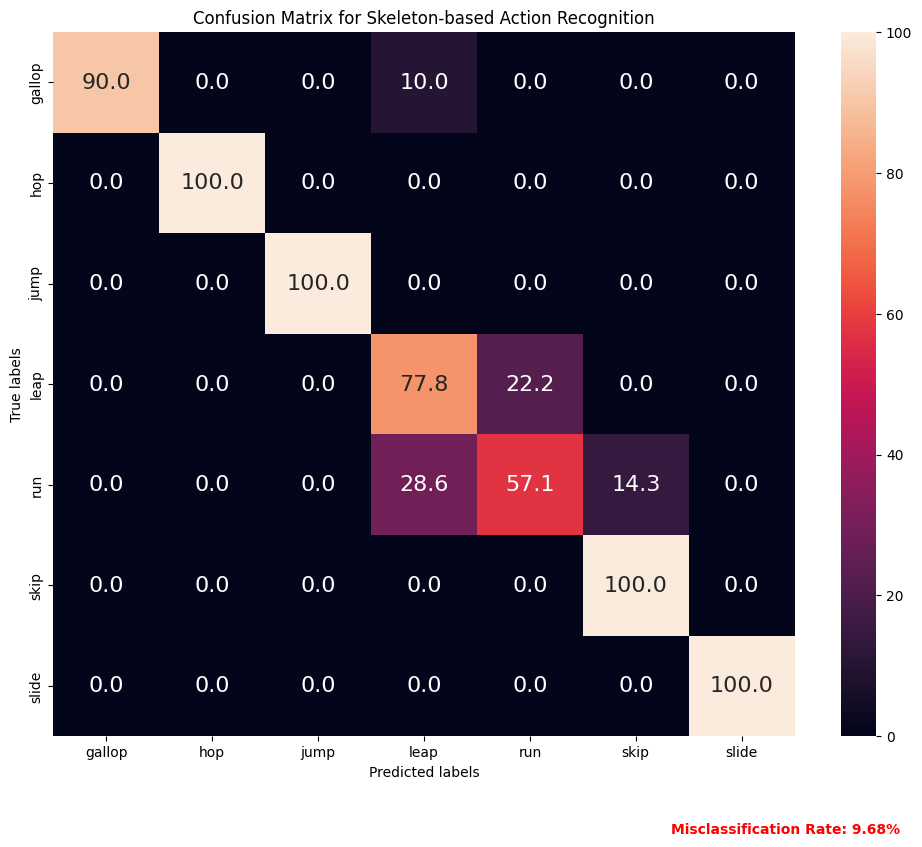

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Given tensor
tensor = torch.tensor([[ 9,  0,  0,  1,  0,  0,  0],
        [ 0,  6,  0,  0,  0,  0,  0],
        [ 0,  0,  2,  0,  0,  0,  0],
        [ 0,  0,  0,  7,  2,  0,  0],
        [ 0,  0,  0,  2,  4,  1,  0],
        [ 0,  0,  0,  0,  0, 10,  0],
        [ 0,  0,  0,  0,  0,  0, 18]])

# Convert tensor to numpy array
cm = tensor.numpy()

# Calculate row sums
row_sums = cm.sum(axis=1, keepdims=True)

# Convert counts to percentages
cm_percentages = cm / row_sums.astype(float) * 100

# Calculate misclassification rate
incorrect = np.sum(cm) - np.sum(np.diag(cm))
total = np.sum(cm)
misclassification_rate = incorrect / total * 100
print(f"incorrect: {incorrect}")
print(f"total: {total}")

# Define class names
CLASS_NAMES = {
    "gallop": 0,
    "hop": 1,
    "jump": 2,
    "leap": 3,
    "run": 4,
    "skip": 5,
    "slide": 6,
}

# Get class labels for axis
class_labels = [k for k in CLASS_NAMES.keys()]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
# sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm_percentages, annot=True, fmt='.1f', cmap='rocket', annot_kws={"size": 16}, 
            xticklabels=class_labels, yticklabels=class_labels)  # font size
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Skeleton-based Action Recognition')
plt.tight_layout()
plt.text(8, 8, f'Misclassification Rate: {misclassification_rate:.2f}%', horizontalalignment='right', verticalalignment='bottom', fontdict={"size": 10, "weight": "bold", "color":"red"})
plt.show()


In [1]:
import argparse

from mmengine import Config
from mmengine.registry import init_default_scope

from mmaction.registry import MODELS

try:
    from mmengine.analysis import get_model_complexity_info
except ImportError:
    raise ImportError('Please upgrade mmcv to >0.6.2')


def get_model_complexity(config_path, input_shape=(224, 224)):
    if len(input_shape) == 1:
        input_shape = (1, 3, input_shape[0], input_shape[0])
    elif len(input_shape) == 2:
        input_shape = (1, 3) + tuple(input_shape)
    elif len(input_shape) == 4:
        input_shape = tuple(input_shape)
    elif len(input_shape) == 5:
        input_shape = tuple(input_shape)
    else:
        raise ValueError('invalid input shape')

    cfg = Config.fromfile(config_path)
    init_default_scope(cfg.get('default_scope', 'mmaction'))
    model = MODELS.build(cfg.model)
    model.eval()

    if hasattr(model, 'extract_feat'):
        model.forward = model.extract_feat
    else:
        raise NotImplementedError(
            'FLOPs counter is currently not currently supported with {}'.
            format(model.__class__.__name__))

    analysis_results = get_model_complexity_info(model, input_shape)
    flops = analysis_results['flops_str']
    params = analysis_results['params_str']
    table = analysis_results['out_table']
    print(table)
    split_line = '=' * 30
    print(f'\n{split_line}\nInput shape: {input_shape}\n'
          f'Flops: {flops}\nParams: {params}\n{split_line}')
    print('!!!Please be cautious if you use the results in papers. '
          'You may need to check if all ops are supported and verify that the '
          'flops computation is correct.')


# Example usage in a notebook:
config_path = '../../configs/pretrained_slowonly_resnet50_gym-keypoint_v2.py'
input_shape = (32, 17, 1, 7, 7)  # or any other input shape you want to use
get_model_complexity(config_path, input_shape)


06/17 13:41:22 - mmengine - WARNING - Unsupported operator aten::max_pool3d encountered 1 time(s)
06/17 13:41:22 - mmengine - WARNING - Unsupported operator aten::add encountered 13 time(s)
06/17 13:41:22 - mmengine - WARNING - The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
backbone.pool2, cls_head, cls_head.avg_pool, cls_head.dropout, cls_head.fc_cls, cls_head.loss_cls, data_preprocessor
06/17 13:41:22 - mmengine - WARNING - Unsupported operator aten::batch_norm encountered 43 time(s)



+--------------------------+----------------------+------------+--------------+
| module                   | #parameters or shape | #flops     | #activations |
+--------------------------+----------------------+------------+--------------+
| model                    | 1.998M               | 0.22G      | 0.997M       |
|  backbone                |  1.994M              |  0.22G     |  0.997M      |
|   backbone.conv1         |   26.72K             |   41.897M  |   50.176K    |
|    backbone.conv1.conv   |    26.656K           |    41.797M |    50.176K   |
|    backbone.conv1.bn     |    64                |    0.1M    |    0         |
|   backbone.layer1        |   72.448K            |   38.242M  |   0.493M     |
|    backbone.layer1.0     |    19.072K           |    10.914M |    0.198M    |
|    backbone.layer1.1     |    17.792K           |    9.11M   |    98.304K   |
|    backbone.layer1.2     |    17.792K           |    9.11M   |    98.304K   |
|    backbone.layer1.3     |    17.792K

In [2]:
import os 

model_size = os.path.getsize("../../results/posec3d/best_acc_top1_epoch_18.pth") / 1000000

print(f"Skeleton-based Action Recognition Model Size: {model_size} MB")

Skeleton-based Action Recognition Model Size: 8.468138 MB


In [3]:
from inference import inference, settings
import time
from pathlib import Path
from constants import globals as g
%load_ext autoreload
%autoreload 2

filename = "hop-trial.mp4"
src_vid = Path(g.TEST_DATA_DIR, filename)

label, score = inference.run_inference(
    video_path=src_vid,
    model_config=settings.MODEL_CONFIG,
    model_checkpoint=settings.MODEL_CHECKPOINT,
    det_config=settings.DET_CONFIG,
    pose_config=settings.POSE_CONFIG,
    label_map=settings.LABEL_MAP,
)
print(
    f"Predicted action: {label.upper()} with confidence score of {round((score*100), 4)}%."
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
06/18 00:42:39 - mmengine - WARNING - The current default scope "mmaction" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".
Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth
Performing Human Detection for each frame
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 13.0 task/s, elapsed: 2s, ETA:     0s
06/18 00:42:42 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".
Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\hrnet_w32_coco_256x192-c78dce93_20200708.pth
Performing Human Pose Estimation for each frame
[                                                  ] 0/30, elapsed: 0s, ETA:

c:\Users\nepom\miniconda3\envs\openmmlab\lib\site-packages\mmpose\apis\inference.py:121: UserWarning: Can not load dataset_meta from the checkpoint or the model config. Use COCO metainfo by default.
  warnings.warn('Can not load dataset_meta from the checkpoint or the '
c:\Users\nepom\miniconda3\envs\openmmlab\lib\site-packages\mmpose\datasets\datasets\utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/coco.py" does not exist. A matched config file "c:\Users\nepom\miniconda3\envs\openmmlab\lib\site-packages\mmpose\.mim\configs\_base_\datasets\coco.py" will be used instead.
  warnings.warn(
c:\Users\nepom\miniconda3\envs\openmmlab\lib\site-packages\mmcv\transforms\loading.py:69: DeprecationWarning: "file_client_args" will be deprecated in future. Please use "backend_args" instead
  warnings.warn(


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 8.4 task/s, elapsed: 4s, ETA:     0s
06/18 00:42:46 - mmengine - WARNING - The current default scope "mmpose" is not "mmaction", `init_default_scope` will force set the currentdefault scope to "mmaction".
Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\PoseC3D-best.pth
Elapsed inference time: 0.6592 seconds
Predicted action: HOP with confidence score of 94.3278%.
